# Neural Network for CAP Classification
### Author: Apurva R Umredkar


In [1]:
#Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#dataset = loadmat("/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N= dataset.shape[0]
mmscaler= MinMaxScaler()

signals= dataset[:,:1024]
signals_dft= np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:,1:513]).reshape((N,512,1))
targets= dataset[:,1024]

from sklearn.utils import shuffle
X, Y= shuffle(inputs, targets, random_state= None)

skfold = StratifiedKFold(n_splits=5)

In [3]:
#Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
  conv1 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv2 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv3 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  maxp = MaxPool1D(pool_size=3, strides= 1, padding= 'same')(layer)

  conv2 = Conv1D(f2, 3, activation= 'relu', padding= 'same')(conv2)
  conv3 = Conv1D(f3, 5, activation= 'relu', padding= 'same')(conv3)
  conv4 = Conv1D(f4, 1, activation= 'relu', padding= 'same')(maxp)

  return Concatenate()([conv1, conv2, conv3, conv4])

input_signal= Input(shape=(512,1))

incept= inception_module(input_signal, 32,64,128,32)
conv= Conv1D(192, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(128, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(128, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,16,32,64,16)
conv= Conv1D(96, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(64, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(64, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,8,16,32,8)
conv= Conv1D(48, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(32, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(32, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,4,8,16,4)
conv= Conv1D(24, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(16, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(16, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,2,4,8,2)
conv= Conv1D(12, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(8, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(8, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

flat = Flatten()(gru)
output= Dense(2, activation='softmax')(flat)

if 'model' in globals() or 'model' in locals(): del model

model= keras.Model(inputs = input_signal, outputs = output)
model.summary()
init_weights = model.get_weights()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

Training for Fold #1
Epoch 1/2500
110/110 [==============================] - 62s 178ms/step - loss: 0.6923 - accuracy: 0.5360 - val_loss: 0.6907 - val_accuracy: 0.5404
Epoch 2/2500
110/110 [==============================] - 16s 142ms/step - loss: 0.6639 - accuracy: 0.5968 - val_loss: 0.6639 - val_accuracy: 0.5932
Epoch 3/2500
110/110 [==============================] - 16s 143ms/step - loss: 0.6474 - accuracy: 0.6284 - val_loss: 0.6540 - val_accuracy: 0.6177
Epoch 4/2500
110/110 [==============================] - 16s 145ms/step - loss: 0.6382 - accuracy: 0.6418 - val_loss: 0.6536 - val_accuracy: 0.6163
Epoch 5/2500
110/110 [==============================] - 16s 145ms/step - loss: 0.6338 - accuracy: 0.6391 - val_loss: 0.6466 - val_accuracy: 0.6262
Epoch 6/2500
110/110 [==============================] - 16s 145ms/step - loss: 0.6288 - accuracy: 0.6452 - val_loss: 0.6406 - val_accuracy: 0.6416
Epoch 7/2500
110/110 [==============================] - 16s 148ms/step - loss: 0.6252 - accuracy:

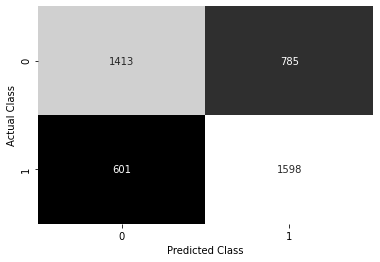

Accuracy Metrics:                 0
count  102.000000
mean     0.682130
std      0.024768
min      0.536001
25%      0.674106
50%      0.685941
75%      0.697651
max      0.716042

Loss Metrics:                 0
count  102.000000
mean     0.581129
std      0.026701
min      0.542055
25%      0.563047
50%      0.577164
75%      0.593672
max      0.692321

Val. Accuracy Metrics:                 0
count  102.000000
mean     0.646198
std      0.014190
min      0.540364
25%      0.645608
50%      0.649233
75%      0.651791
max      0.662024

Val. Loss Metrics:                 0
count  102.000000
mean     0.619222
std      0.013073
min      0.606048
25%      0.611288
50%      0.615944
75%      0.621412
max      0.690660


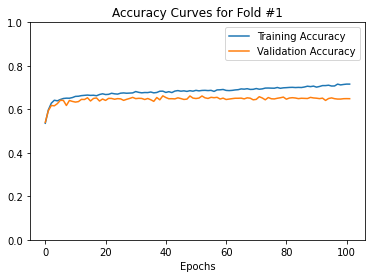

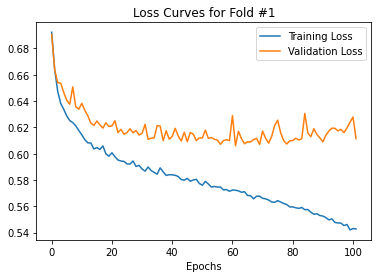

Training for Fold #2
Epoch 1/2500
110/110 [==============================] - 26s 166ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 2/2500
110/110 [==============================] - 16s 150ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 3/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6930 - accuracy: 0.5211 - val_loss: 0.6930 - val_accuracy: 0.4889
Epoch 4/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6925 - accuracy: 0.5304 - val_loss: 0.6924 - val_accuracy: 0.5412
Epoch 5/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6912 - accuracy: 0.5733 - val_loss: 0.6910 - val_accuracy: 0.5540
Epoch 6/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6883 - accuracy: 0.5809 - val_loss: 0.6888 - val_accuracy: 0.5475
Epoch 7/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6834 - accuracy:

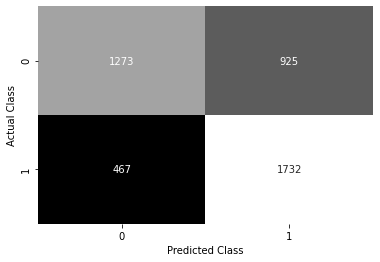

Accuracy Metrics:                 0
count  137.000000
mean     0.674885
std      0.041679
min      0.498401
25%      0.669344
50%      0.681356
75%      0.696709
max      0.732319

Loss Metrics:                 0
count  137.000000
mean     0.589495
std      0.040011
min      0.517133
25%      0.562388
50%      0.582932
75%      0.610393
max      0.693150

Val. Accuracy Metrics:                 0
count  137.000000
mean     0.641792
std      0.032582
min      0.488914
25%      0.644969
50%      0.651222
75%      0.654633
max      0.663445

Val. Loss Metrics:                 0
count  137.000000
mean     0.625862
std      0.021812
min      0.601910
25%      0.609429
50%      0.619229
75%      0.634552
max      0.693190


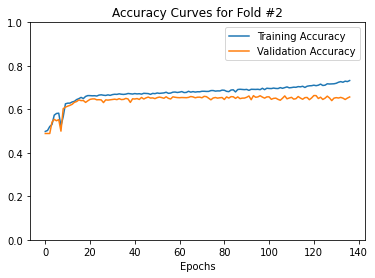

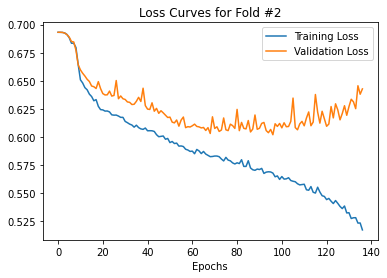

Training for Fold #3
Epoch 1/2500
110/110 [==============================] - 27s 169ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 2/2500
110/110 [==============================] - 17s 155ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 3/2500
110/110 [==============================] - 18s 162ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 4/2500
110/110 [==============================] - 16s 150ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 5/2500
110/110 [==============================] - 17s 150ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 6/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6929 - accuracy: 0.5027 - val_loss: 0.6929 - val_accuracy: 0.4889
Epoch 7/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6923 - accuracy:

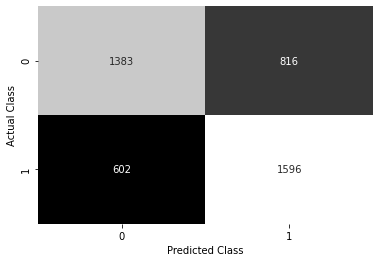

Accuracy Metrics:                 0
count  123.000000
mean     0.672282
std      0.047177
min      0.502737
25%      0.669202
50%      0.686616
75%      0.697740
max      0.713839

Loss Metrics:                 0
count  123.000000
mean     0.586575
std      0.040383
min      0.539857
25%      0.558216
50%      0.574079
75%      0.599097
max      0.693150

Val. Accuracy Metrics:                 0
count  123.000000
mean     0.638581
std      0.040012
min      0.488914
25%      0.639994
50%      0.652644
75%      0.659608
max      0.668277

Val. Loss Metrics:                 0
count  123.000000
mean     0.618927
std      0.027296
min      0.595068
25%      0.600340
50%      0.608484
75%      0.627200
max      0.693212


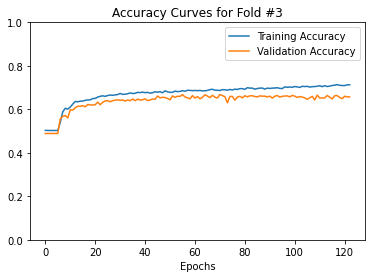

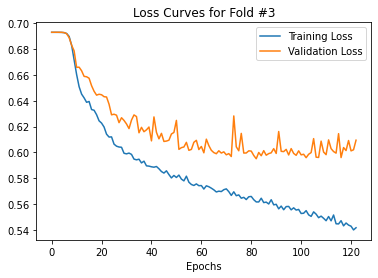

Training for Fold #4
Epoch 1/2500
110/110 [==============================] - 26s 165ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 2/2500
110/110 [==============================] - 17s 153ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 3/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 4/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 5/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 6/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4889
Epoch 7/2500
110/110 [==============================] - 17s 150ms/step - loss: 0.6931 - accuracy:

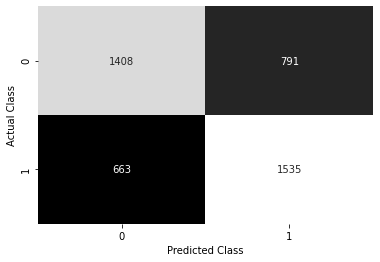

Accuracy Metrics:                 0
count  135.000000
mean     0.675049
std      0.055659
min      0.495273
25%      0.671085
50%      0.690241
75%      0.704030
max      0.737437

Loss Metrics:                 0
count  135.000000
mean     0.581764
std      0.043358
min      0.517320
25%      0.555023
50%      0.571759
75%      0.595312
max      0.693156

Val. Accuracy Metrics:                 0
count  135.000000
mean     0.636683
std      0.043484
min      0.488914
25%      0.643690
50%      0.650938
75%      0.654918
max      0.667140

Val. Loss Metrics:                 0
count  135.000000
mean     0.623050
std      0.024428
min      0.599657
25%      0.608016
50%      0.614285
75%      0.628341
max      0.693249


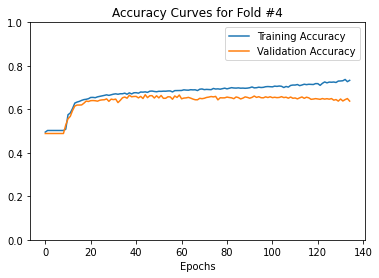

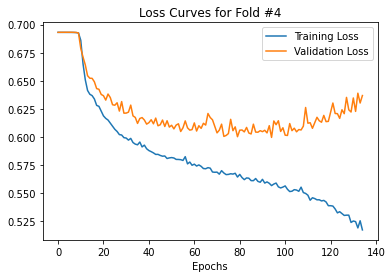

Training for Fold #5
Epoch 1/2500
110/110 [==============================] - 29s 187ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6932 - val_accuracy: 0.4864
Epoch 2/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6932 - accuracy: 0.5034 - val_loss: 0.6932 - val_accuracy: 0.4864
Epoch 3/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4864
Epoch 4/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4864
Epoch 5/2500
110/110 [==============================] - 17s 151ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4864
Epoch 6/2500
110/110 [==============================] - 17s 152ms/step - loss: 0.6931 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.4864
Epoch 7/2500
110/110 [==============================] - 17s 153ms/step - loss: 0.6931 - accuracy:

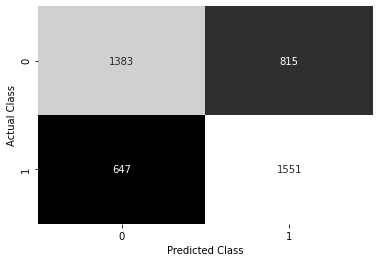

Accuracy Metrics:                 0
count  143.000000
mean     0.675542
std      0.057745
min      0.503412
25%      0.672175
50%      0.687065
75%      0.704264
max      0.754797

Loss Metrics:                 0
count  143.000000
mean     0.580749
std      0.047770
min      0.492792
25%      0.552458
50%      0.573772
75%      0.597893
max      0.693151

Val. Accuracy Metrics:                 0
count  143.000000
mean     0.651377
std      0.048263
min      0.486356
25%      0.654918
50%      0.666856
75%      0.673394
max      0.683911

Val. Loss Metrics:                 0
count  143.000000
mean     0.608962
std      0.030529
min      0.580287
25%      0.589402
50%      0.597989
75%      0.617832
max      0.693311


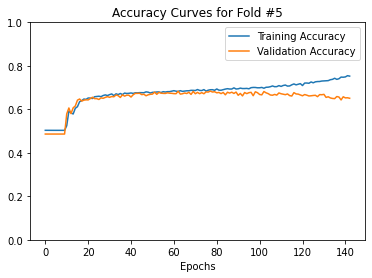

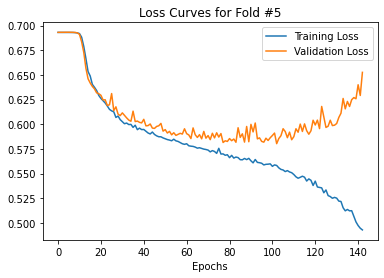

In [4]:
#Hyperparameters
epochs= 2500
batch_size= 128
validation_split= 0.2
lr = 1e-4
early_stop= keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1, patience=40, restore_best_weights=True)
opt= keras.optimizers.Adam(learning_rate=lr)

total_confmat = np.zeros((2,2))
fold_num=1
total_history = []
total_results = []

start = time.time()
for train, test in skfold.split(X,Y):
  X_train, X_test = X[train], X[test]
  Y_train =  to_categorical(Y[train])                                                        
  Y_test =  to_categorical(Y[test])

  keras.backend.clear_session()
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  model.set_weights(init_weights)
  model.reset_states()

  print(f'Training for Fold #{fold_num}')
  history = model.fit(X_train, Y_train, validation_split= validation_split, epochs =epochs, batch_size=batch_size, verbose =1, callbacks=[early_stop])
  res = model.evaluate(X_test, Y_test)

  total_history.append(history)
  total_results.append(res)

  #Prediction
  Ypred = model.predict(X_test)
  Ypred = np.round(Ypred)
  print(classification_report(Y_test,Ypred))

  #Confusion Matrix
  confmat = confusion_matrix(Y_test.argmax(axis=1),Ypred.argmax(axis=1))
  confmat_heatmap = sns.heatmap(confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

  total_confmat+= confmat

  #Stats of Metrics
  acc = pd.DataFrame(history.history['accuracy'])
  loss  = pd.DataFrame(history.history['loss'])
  valacc = pd.DataFrame(history.history['val_accuracy'])
  valloss = pd.DataFrame(history.history['val_loss'])
  print(f'Accuracy Metrics: {acc.describe()}\n')
  print(f'Loss Metrics: {loss.describe()}\n')
  print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
  print(f'Val. Loss Metrics: {valloss.describe()}')

  #Plots
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training Accuracy','Validation Accuracy'])
  plt.xlabel('Epochs')
  plt.title(label=f'Accuracy Curves for Fold #{fold_num}')
  plt.ylim(0,1)
  plt.show()
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epochs')
  plt.title(label=f'Loss Curves for Fold #{fold_num}')
  plt.show()

  fold_num+=1
  
end = time.time()

In [5]:
np.mean(np.array(total_results)[:,1]), np.std(np.array(total_results)[:,1])

(0.6764915823936463, 0.007091691228698788)

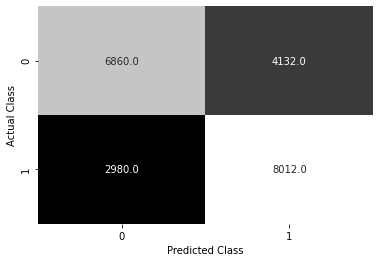

In [6]:
  confmat_heatmap = sns.heatmap(total_confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

In [7]:
total_results

[[0.5842606425285339, 0.6847850680351257],
 [0.5831626653671265, 0.6834205389022827],
 [0.5858351588249207, 0.6775074005126953],
 [0.5858792662620544, 0.6693199872970581],
 [0.5930030345916748, 0.6674249172210693]]